In [2]:

import torch.nn.functional as F

from tc.lra_datasets import (ListOpsDataset, Cifar10Dataset, ImdbDataset)
from argparse import ArgumentParser
from accelerate import Accelerator
from algo import (
    PITOME,
    TOME,
    DIFFRATE,
    TOFU,
    DCT,
    NONE
)
from tc.engine import Engine, BERT_BASE, DISTILBERT_BASE, BERT_LARGE




In [14]:


# consts
OUTPUT_DIR = "output_dir/"
deepspeed_json = "ds_config.json"

TASKS = [
    'sst2',
    'imdb',
    'rotten',
    'bbc',
]

model_dict = {
    BERT_BASE: 'BERT-B',
    DISTILBERT_BASE: 'DISTILEDBERT-B',
    BERT_LARGE: 'BERT-L'
}


batch_size = 1 
avg_factor = 0.95
task_name = 'imdb'
algo = PITOME 

engine = Engine(
    task_name=task_name,
    model_ckt=BERT_BASE,
    ratio=0.8,
    algo=PITOME,
    batch_size=1,
    enable_log=False,
    trained=True
)

                

JiaqiLee/imdb-finetuned-bert-base-uncased


using pitome


In [77]:
for sample in engine.train_loader: 
    input = sample
    print(sample[0]['input_ids'].shape)
    break

torch.Size([1, 92])


In [78]:
input[0]

{'input_ids': tensor([[  101,  6517,  2466,  1997,  1037, 20164,  1038,  1011,  2459,  4405,
          1012, 10184,  2003,  2915,  2091,  2058,  4548,  3700,  1012,  1996,
          2334,  8086,  2545,  3668,  2032, 16056,  1998,  3860,  2012,  1996,
          3465,  1997,  2037,  2219,  3268,  1012,  1045,  2018,  2196,  2657,
          1997,  2023,  3185,  1998,  2009,  1055,  2532, 15567,  2033,  2005,
          2048,  2847,  1012,  2044,  1996,  2143,  2003,  2058,  1010,  1045,
          1005,  1049,  5580,  1045,  2165,  1996,  2051,  1012,  2009,  1005,
          1055,  2019,  2972,  2466,  2409,  2000,  4863,  1996,  2298,  2006,
         10184,  1005,  1055,  2227,  2012,  1996,  2707,  1997,  1996,  2143,
          1012,   102]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [79]:
output = engine.model(**input[0], return_dict=False, output_hidden_states=True)


In [80]:
len(output[1])

for hidden_state in output[1]:
    print(hidden_state.squeeze().shape)

torch.Size([92, 768])
torch.Size([74, 768])
torch.Size([60, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])
torch.Size([49, 768])


In [89]:
import math
import torch
def pitome_text(
    metric: torch.Tensor, 
    ratio:float=1.0,
    attn:torch.Tensor = None,
    margin:torch.Tensor=0.5,
    class_token: bool = False,
    training:bool=False
):

    with torch.no_grad():
        if class_token:
            metric=metric[:,1:,:]

        if len(metric.shape) == 2:
            metric = metric[None,...]
        B,T,C = metric.shape
        r = math.floor(T- T*ratio)
        metric = F.normalize(metric, p=2, dim=-1) 

        batch_idx = torch.arange(B).unsqueeze_(1).to(metric.device)
        sim = metric@metric.transpose(-1,-2)
        sigma = 1 - margin 
        isolation_score = (torch.exp(-(((1 - sim)/sigma)**2 * 0.5))).mean(-1) *  1/(sigma*torch.sqrt(torch.tensor(2*torch.pi))) 
        indices =  torch.argsort(isolation_score, descending=True)

    with torch.no_grad():
        merge_idx = indices[..., :2*r]
        protected_idx = indices[..., 2*r:]
        a_idx = merge_idx[..., :r]
        b_idx = merge_idx[..., r:]
        scores = sim.gather(dim=-1, index=b_idx.unsqueeze(-2).expand(B, T, b_idx.shape[-1])) 
        scores = scores.gather(dim=-2, index=a_idx.unsqueeze(-1).expand(B, a_idx.shape[-1], b_idx.shape[-1] ))
        _, dst_idx = scores.max(dim=-1) 

    def merge(x: torch.Tensor, mode="mean") -> torch.Tensor:
        if class_token:
            x_cls=x[:,0,:].unsqueeze(1)
            x=x[:,1:,:]
        else:
            x_cls = None

        B, T, C = x.shape
        src, dst = x[batch_idx, a_idx, :], x[batch_idx,  b_idx, :]
        dst = dst.scatter_reduce(-2, dst_idx.unsqueeze(2).expand(B, r, C), src, reduce=mode)
        # protected = x[batch_idx, protected_idx, :]
        dst = x[batch_idx,  b_idx, :]

        if x_cls is not None:
            return torch.cat([x_cls, dst], dim=1)
        else:
            return torch.cat([dst], dim=1)

    isolation_score = 1 - F.softmax(isolation_score, dim=-1) 

    if class_token:
        return merge, torch.cat([torch.ones(B, 1).to(metric.device), isolation_score], dim=-1)[..., None]
    return merge, isolation_score[..., None], a_idx, dst_idx


In [90]:

def do_nothing(x, mode=None):
    return x


def bipartite_soft_matching(
    metric: torch.Tensor,
    r: int=0,
    ratio:float=1.0,    
    class_token: bool = False,
    distill_token: bool = False,
):
    
    protected = 0
    if class_token:
        protected += 1
    if len(metric.shape) == 2:
        metric = metric[None,...]

    # We can only reduce by a maximum of 50% tokens
    T = metric.shape[1]
    
    if r > 0:
        r = min(r, (T-protected) // 2)
    elif ratio < 1.0:
        r = math.floor(T- T*ratio)
    else:
        return do_nothing, do_nothing


    with torch.no_grad():
        metric = metric / metric.norm(dim=-1, keepdim=True)
        a, b = metric[..., ::2, :], metric[..., 1::2, :]
        scores = a @ b.transpose(-1, -2)

        if class_token:
            scores[..., 0, :] = -math.inf

        node_max, node_idx = scores.max(dim=-1)
        edge_idx = node_max.argsort(dim=-1, descending=True)[..., None]

        unm_idx = edge_idx[..., r:, :]  # Unmerged Tokens
        src_idx = edge_idx[..., :r, :]  # Merged Tokens
        dst_idx = node_idx[..., None].gather(dim=-2, index=src_idx)

        if class_token:
            unm_idx = unm_idx.sort(dim=1)[0]

    def merge(x: torch.Tensor, mode="mean") -> torch.Tensor:
        src, dst = x[..., ::2, :], x[..., 1::2, :]
        n, t1, c = src.shape
        unm = src.gather(dim=-2, index=unm_idx.expand(n, t1 - r, c))
        src = src.gather(dim=-2, index=src_idx.expand(n, r, c))
        dst = dst.scatter_reduce(-2, dst_idx.expand(n, r, c), src, reduce=mode)

        return torch.cat([unm, dst], dim=1)
    

    return merge, src_idx, dst_idx 



In [91]:
import matplotlib
import matplotlib.patches as patches
import seaborn as sns

class CustomArrow(patches.FancyArrowPatch):
    def __init__(self, start_point, end_point, **kwargs):
        super().__init__(start_point, end_point, **kwargs)

    def draw(self, renderer):
        # Customize arrow drawing behavior here if needed
        super().draw(renderer)

In [95]:
import torch
from sklearn.manifold import TSNE  # For t-SNE dimensionality reduction
import matplotlib.pyplot as plt  # For plotting

layer_idx = 0
_,_, a_idx, b_idx = pitome_text(output[1][layer_idx], ratio=0.8)
a_idx= a_idx.squeeze().detach().cpu().numpy()
b_idx= b_idx.squeeze().detach().cpu().numpy()
data = output[1][layer_idx].squeeze().detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
data_embedded = tsne.fit_transform(data)


In [98]:

_, a_idx, b_idx = bipartite_soft_matching(output[1][layer_idx], ratio=0.8)
a_idx= a_idx.squeeze().detach().cpu().numpy()
b_idx= b_idx.squeeze().detach().cpu().numpy()
data = output[1][layer_idx].squeeze().detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
data_embedded = tsne.fit_transform(data)

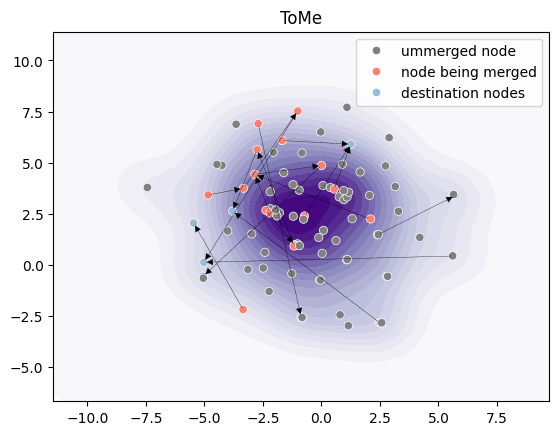

In [99]:
# def plot_embeddings(data_embedded, a_idx, b_idx):
labels = []
for i in range(data_embedded.shape[0]):
    if i in a_idx:
        labels.append('node being merged')
        
    elif i in b_idx:
        labels.append('destination nodes')
    else: 
        labels.append('ummerged node')

palette= {'ummerged node':'grey', 'node being merged':'#fb8072', 'destination nodes':'#98bad5'}
sns.kdeplot(x=data_embedded[:, 0], y=data_embedded[:, 1], levels=20, thresh=1e-55, fill=True, cmap='Purples')  # Scatter plot of transformed data
sns.scatterplot(x=data_embedded[:, 0], y=data_embedded[:, 1], hue=labels, palette=palette)  # Scatter plot of transformed data
arrow_props = {'color':'black', 'linewidth':0.3, 'arrowstyle': '-|>' ,'mutation_scale':10.0,'linestyle':'--'}  # Adjust as needed


# Iterate through data and add custom arrows
for i in range(len(a_idx)):
    src_x, src_y=data_embedded[a_idx[i], 0], data_embedded[a_idx[i], 1]  
    dst_x, dst_y=data_embedded[b_idx[i], 0], data_embedded[b_idx[i], 1]  
    arrow = CustomArrow((src_x, src_y), (dst_x, dst_y), **arrow_props)
    plt.gca().add_artist(arrow)
    # ... rest of your plot customizations (labels, title, etc.)
plt.title('ToMe')
plt.show()


In [100]:
layer_idx = 0
_,_, a_idx, b_idx = pitome_text(output[1][layer_idx], ratio=0.8)
a_idx= a_idx.squeeze().detach().cpu().numpy()
b_idx= b_idx.squeeze().detach().cpu().numpy()
data = output[1][layer_idx].squeeze().detach().cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
data_embedded = tsne.fit_transform(data)


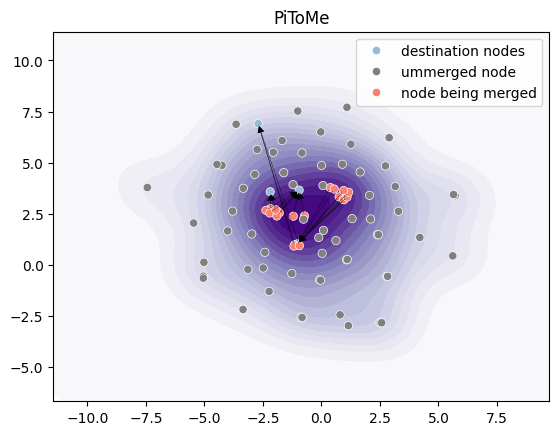

In [101]:
# def plot_embeddings(data_embedded, a_idx, b_idx):
labels = []
for i in range(data_embedded.shape[0]):
    if i in a_idx:
        labels.append('node being merged')
        
    elif i in b_idx:
        labels.append('destination nodes')
    else: 
        labels.append('ummerged node')

palette= {'ummerged node':'grey', 'node being merged':'#fb8072', 'destination nodes':'#98bad5'}
sns.kdeplot(x=data_embedded[:, 0], y=data_embedded[:, 1], levels=20, thresh=1e-55, fill=True, cmap='Purples')  # Scatter plot of transformed data
sns.scatterplot(x=data_embedded[:, 0], y=data_embedded[:, 1], hue=labels, palette=palette)  # Scatter plot of transformed data
arrow_props = {'color':'black', 'linewidth':0.3, 'arrowstyle': '-|>' ,'mutation_scale':10.0,'linestyle':'--'}  # Adjust as needed


# Iterate through data and add custom arrows
for i in range(len(a_idx)):
    src_x, src_y=data_embedded[a_idx[i], 0], data_embedded[a_idx[i], 1]  
    dst_x, dst_y=data_embedded[b_idx[i], 0], data_embedded[b_idx[i], 1]  
    arrow = CustomArrow((src_x, src_y), (dst_x, dst_y), **arrow_props)
    plt.gca().add_artist(arrow)
    # ... rest of your plot customizations (labels, title, etc.)
plt.title('PiToMe')
plt.show()
